In [1]:
import torch
from torch.utils.data import DataLoader,Dataset, ConcatDataset,random_split
from torchsummary import summary
import multiprocessing
import torch.nn.functional as F
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import random
import cv2
import re

In [2]:
!nvidia-smi

Mon Dec  9 23:03:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:86:00.0 Off |                    0 |
| N/A   39C    P0              59W / 300W |      0MiB / 32768MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

class OverFeat(nn.Module):
    def __init__(self):
        super(OverFeat, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(7,7), stride=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=(3, 3), stride=3)

        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(7,7), stride=1)
        self.maxp2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3), stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.maxp6 = nn.MaxPool2d(kernel_size=(3,3), stride=3)

        self.linear1 = nn.Linear(1024 * 5 * 5, 4096)
        self.linear2 = nn.Linear(4096, 4096)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxp1(x)

        x = F.relu(self.conv2(x))
        x = self.maxp2(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxp6(x)

        x =torch.flatten(x,1)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        return x

In [4]:
class CustomPairwiseDataset(Dataset):
    def __init__(self, img_directory, matrix_file):
        self.img_directory = img_directory
        self.matrix = np.loadtxt(matrix_file, delimiter=',')
        self.image_files = sorted(os.listdir(img_directory))
        self.matrix_shape = self.matrix.shape
        self.pairs = self._create_pairs()
        self._sample_pairs()

        # Focal length:
        fc = [ 367.481519978327754 , 366.991059667167065 ]
        # Principal point:
        cc = [ 328.535778962615268 , 233.779960757465176 ]
        # Distortion coefficients:
        kc = [ -0.293510277812333,
                0.065334967950619,
            -0.000117308680498,
                0.000304779905426,
                0.000000000000000 ]
        
        # Camera matrix
        self.camera_matrix = np.array([
            [fc[0], 0, cc[0]],
            [0, fc[1], cc[1]],
            [0, 0, 1]
        ], dtype=np.float32)
        
        self.im_width  = 640
        self.im_height = 480

        # Distortion coefficients
        self.dist_coeffs = np.array(kc, dtype=np.float32)

    def __len__(self):
        return len(self.pairs)
    
    def _create_pairs(self):
        pairs = []
        n = self.matrix.shape[0]
        for i in range(n):
            for j in range(i):
                if i==j:
                    continue
                label = self.matrix[i, j]
                pairs.append((i, j, label))
        return pairs
    
    def _sample_pairs(self):
        #very large number of 0s compared to 1s in pair labels
        #sample pairs with label 0 such that they are equal to number of
        #pairs with label 1

        # Separate pairs by label
        label_1_pairs = [(r, c, l) for (r, c, l) in self.pairs if l == 1]
        label_0_pairs = [(r, c, l) for (r, c, l) in self.pairs if l == 0]

        # Sample label 0 pairs
        n_label_0 = len(label_0_pairs)
        n_label_1 = len(label_1_pairs)
        print("n_0:", n_label_0, "n_1:", n_label_1)

        random.seed(42)
        sampled_label_0_pairs = random.sample(label_0_pairs, n_label_1)
        self.pairs = sampled_label_0_pairs + label_1_pairs
        random.shuffle(self.pairs)
        print("Total pairs after sampling:", len(self.pairs))

    def _transform(self, img_x):
        #normalize image x
        transform = transforms.Compose([
            transforms.ToTensor(),
            #using mean and standard deviation of imagenet dataset
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            transforms.Resize((221, 221), antialias=True)
        ])
        return transform(img_x)

    def __getitem__(self, index):

        img1_idx, img2_idx, label = self.pairs[index]
        img1_path = os.path.join(self.img_directory, self.image_files[img1_idx])
        img2_path = os.path.join(self.img_directory, self.image_files[img2_idx])
        
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        undistorted_img1 = cv2.undistort(img1, self.camera_matrix, self.dist_coeffs)
        undistorted_img2 = cv2.undistort(img2, self.camera_matrix, self.dist_coeffs)

        transformed_img1 = self._transform(undistorted_img1)
        transformed_img2 = self._transform(undistorted_img2)
        
        return transformed_img1, transformed_img2, torch.tensor(label, dtype=torch.float32)


In [5]:
#create dataloaders for CityCentre and NewCollege datasets
def createCombinedDataset(image_dirs, gt_matrix_paths):

    datasets = []
    for image_dir, gt_matrix in zip(image_dirs, gt_matrix_paths):
        datasets.append(CustomPairwiseDataset(image_dir, gt_matrix))
    
    combined_dataset = ConcatDataset(datasets)

    return combined_dataset

def contrastive_loss(distances, label, margin=1.0):
    loss = label * distances.pow(2) + (1 - label) * F.relu(margin - distances).pow(2)
    return loss.mean()

def calculate_accuracy(distances, labels, threshold=0.5):
    normalized_distances = (distances - distances.min()) / (distances.max() - distances.min())
    predictions = (normalized_distances <= threshold).float()
    correct_predictions = (predictions == labels).sum().item()
    accuracy = correct_predictions / labels.size(0)
    return accuracy

def train_step(model, dataloader, optimizer, device, log_interval=500):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for batch_idx, (img1, img2, labels) in tqdm(enumerate(dataloader), desc='Training', total=len(dataloader), ncols=200):  
        #move data to appropriate device
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        features1 = model(img1)
        features2 = model(img2)
        distances = torch.norm(features1 - features2, p=2, dim=1)

        loss = contrastive_loss(distances, labels)

        #backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate batch accuracy
        accuracy = calculate_accuracy(distances, labels)

        total_loss += loss.item()
        total_accuracy += accuracy

        if (batch_idx + 1) % log_interval == 0:
                print(f"Training Batch {batch_idx + 1}/{len(dataloader)} - Loss: {loss.item():.4f}, "
                      f"Avg Loss: {total_loss / (batch_idx + 1):.4f}, Accuracy: {accuracy:.4f}, "
                      f"Avg Accuracy: { total_accuracy / (batch_idx + 1):.4f}")
    

    return total_loss / len(dataloader), total_accuracy / len(dataloader)

def validation_step(model, dataloader, device, log_interval=250):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for batch_idx, (img1, img2, labels) in tqdm(enumerate(dataloader), desc='Validation', total=len(dataloader), ncols=200):
            #move data to appropriate device
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            features1 = model(img1)
            features2 = model(img2)
            distances = torch.norm(features1 - features2, p=2, dim=1)

            loss = contrastive_loss(distances, labels)
            accuracy = calculate_accuracy(distances, labels)

            total_loss += loss.item()
            total_accuracy += accuracy
            

            if (batch_idx + 1) % log_interval == 0:
                print(f"Validation Batch {batch_idx + 1}/{len(dataloader)} - Loss: {loss.item():.4f}, "
                      f"Avg Loss: {total_loss / (batch_idx + 1):.4f}, Accuracy: {accuracy:.4f}, "
                      f"Avg Accuracy: { total_accuracy / (batch_idx + 1):.4f}")

    return total_loss / len(dataloader), total_accuracy / len(dataloader)

In [6]:
def get_epoch_num(filename):
    pattern = r'model_epoch_(\d+)\.pth'
    match = re.search(pattern, filename)
    
    if match:
        return int(match.group(1))
    else:
        raise ValueError("Filename does not match expected pattern")

In [7]:
image_dirs = ['data/CityCentre_Images',
              'data/NewCollege_Images']
gt_matrix_paths = ['data/CityCentreTextFormat.txt',
                   'data/NewCollegeTextFormat.txt']

combined_dataset = createCombinedDataset(image_dirs, gt_matrix_paths)

#Split dataset into train and testsets
train_size = int(0.8 * len(combined_dataset))
validation_size = len(combined_dataset) - train_size
train_dataset, validation_dataset = random_split(combined_dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(42))

#print length of combined dataset
print('Length of Combined Dataset:',len(combined_dataset))

n_0: 3032125 n_1: 26976
Total pairs after sampling: 53952
n_0: 2286753 n_1: 14832
Total pairs after sampling: 29664
Length of Combined Dataset: 83616


In [8]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=4, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=8, prefetch_factor=4, pin_memory=True)

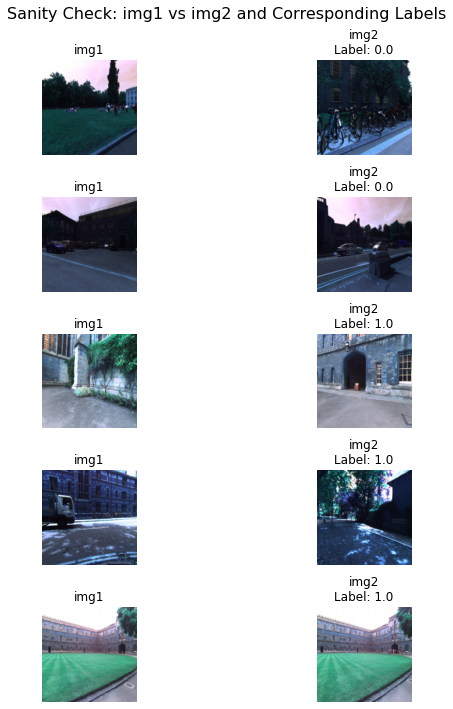

In [9]:
def reverse_transform(tensor):
    """
    Reverse the preprocessing transformations: Normalize -> Convert to PIL Image
    """
    # Imagenet mean and std for normalization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    # Undo normalization
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    
    # Clip values to [0, 1] (in case normalization introduces out-of-bounds values)
    tensor = torch.clamp(tensor, 0, 1)
    
    # Convert to NumPy array
    img = tensor.permute(1, 2, 0).numpy()  # C x H x W -> H x W x C for Matplotlib
    img = (img * 255).astype(np.uint8)  # Scale to [0, 255] for visualization
    
    return img

def plot_dataloader_samples(dataloader, num_samples=5, figsize=(10, 10)):
    # Get one batch of data
    img1_batch, img2_batch, labels_batch = next(iter(dataloader))
    
    # Define a grid for displaying images
    fig, axes = plt.subplots(num_samples, 2, figsize=figsize)
    fig.suptitle("Sanity Check: img1 vs img2 and Corresponding Labels", fontsize=16)

    for i in range(num_samples):
        # Convert tensors to numpy for plotting
        img1 = reverse_transform(img1_batch[i])  # Convert tensor to PIL image
        img2 = reverse_transform(img2_batch[i])  # Convert tensor to PIL image
        label = labels_batch[i].item()
        
        # Plot img1
        
        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"img1")

        # Plot img2
        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"img2\nLabel: {label}")
    
    plt.tight_layout()
    plt.show()
    
plot_dataloader_samples(train_dataloader, num_samples=5)

In [ ]:
# Device setup for compatibility with Mac, CUDA, or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Using device:', device)

model = OverFeat()
# print(summary(model, input_size=(3, 221, 221)))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

load_from_state_dict = True
if load_from_state_dict is True:
    epoch_to_load = 5
    checkpoint = torch.load(f'4096_dims/checkpoint_{epoch_to_load}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    current_epoch = checkpoint['epoch']
    training_losses = checkpoint['training_losses']
    validation_losses = checkpoint['validation_losses']
    training_accs = checkpoint['training_accs']
    validation_accs = checkpoint['validation_accs']
    
    print('Checkpoint loaded successfully.')

else:
    current_epoch = 0

    training_losses = []
    validation_losses = []
    training_accs = []
    validation_accs = []
    
print("last training and validation acc:", training_accs[-1], validation_accs[-1])
print("last training and validation losses:", training_losses[-1], validation_losses[-1])
#current epoch till chkpt 4 is 1, and chkpt 5 is 4 (error in code) but weights are correct
print('Current Epoch Number:', current_epoch)

for epoch in range(current_epoch,epochs+1):
    train_loss, train_accuracy = train_step(model, train_dataloader, optimizer, device)
    validation_loss, validation_accuracy = validation_step(model, validation_dataloader, device)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy} Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')

    training_losses.append(train_loss)
    validation_losses.append(validation_loss)
    training_accs.append(train_accuracy)
    validation_accs.append(validation_accuracy)
    

    checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1, 
    'training_losses': training_losses,
    'validation_losses': validation_losses,
    'training_accs': training_accs,
    'validation_accs': validation_accs
}
    torch.save(checkpoint, f'4096_dims/checkpoint_{epoch+1}.pth')

Using device: cuda
Checkpoint loaded successfully.
last training and validation acc: 0.687221026622031 0.7469885277246654
last training and validation losses: 0.2229395287208498 0.15152120199873617
Current Epoch Number: 5


Training:  24%|███████████████████████████████████▊                                                                                                                  | 500/2091 [05:36<15:50,  1.67it/s]

Training Batch 500/2091 - Loss: 0.1587, Avg Loss: 0.1445, Accuracy: 0.7812, Avg Accuracy: 0.7424


Training:  48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 1000/2091 [11:08<07:58,  2.28it/s]

Training Batch 1000/2091 - Loss: 0.1763, Avg Loss: 0.1354, Accuracy: 0.6250, Avg Accuracy: 0.7488


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1500/2091 [16:47<10:51,  1.10s/it]

Training Batch 1500/2091 - Loss: 0.0765, Avg Loss: 0.1291, Accuracy: 0.8750, Avg Accuracy: 0.7526


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2001/2091 [22:16<00:30,  2.91it/s]

Training Batch 2000/2091 - Loss: 0.0824, Avg Loss: 0.1244, Accuracy: 0.9062, Avg Accuracy: 0.7560


Validation:  48%|████████████████████████████████████████████████████████████████████████                                                                             | 253/523 [02:49<02:07,  2.12it/s]

Validation Batch 250/523 - Loss: 0.1478, Avg Loss: 0.1027, Accuracy: 0.7500, Avg Accuracy: 0.7887


Validation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 503/523 [05:33<00:08,  2.46it/s]

Validation Batch 500/523 - Loss: 0.1220, Avg Loss: 0.1037, Accuracy: 0.7188, Avg Accuracy: 0.7857


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [05:43<00:00,  1.52it/s]


Epoch 6/10, Train Loss: 0.12340360983051733, Train Accuracy: 0.7565459110473458 Validation Loss: 0.10389873308501782, Validation Accuracy: 0.7858389101338432


Training:  24%|███████████████████████████████████▊                                                                                                                  | 500/2091 [05:36<14:47,  1.79it/s]

Training Batch 500/2091 - Loss: 0.0541, Avg Loss: 0.0960, Accuracy: 0.9688, Avg Accuracy: 0.7871


Training:  48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 1000/2091 [11:06<09:45,  1.86it/s]

Training Batch 1000/2091 - Loss: 0.1067, Avg Loss: 0.0941, Accuracy: 0.3438, Avg Accuracy: 0.7844


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1500/2091 [16:40<04:01,  2.45it/s]

Training Batch 1500/2091 - Loss: 0.0941, Avg Loss: 0.0916, Accuracy: 0.8750, Avg Accuracy: 0.7887


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2001/2091 [22:16<01:09,  1.29it/s]

Training Batch 2000/2091 - Loss: 0.1345, Avg Loss: 0.0898, Accuracy: 0.7812, Avg Accuracy: 0.7897


Validation:  48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 250/523 [02:49<03:14,  1.40it/s]

Validation Batch 250/523 - Loss: 0.1057, Avg Loss: 0.0794, Accuracy: 0.8438, Avg Accuracy: 0.8005


Validation:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 500/523 [05:32<00:13,  1.76it/s]

Validation Batch 500/523 - Loss: 0.1117, Avg Loss: 0.0789, Accuracy: 0.6562, Avg Accuracy: 0.8075


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [05:42<00:00,  1.53it/s]


Epoch 7/10, Train Loss: 0.08968017837331091, Train Accuracy: 0.7897138530208831 Validation Loss: 0.079151861401663, Validation Accuracy: 0.8059273422562141


Training:  24%|███████████████████████████████████▉                                                                                                                  | 501/2091 [05:42<16:17,  1.63it/s]

Training Batch 500/2091 - Loss: 0.0911, Avg Loss: 0.0703, Accuracy: 0.7188, Avg Accuracy: 0.7935


Training:  48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 1001/2091 [11:12<04:38,  3.92it/s]

Training Batch 1000/2091 - Loss: 0.0479, Avg Loss: 0.0710, Accuracy: 0.5938, Avg Accuracy: 0.7945


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1501/2091 [16:50<05:44,  1.71it/s]

Training Batch 1500/2091 - Loss: 0.0555, Avg Loss: 0.0707, Accuracy: 0.8750, Avg Accuracy: 0.7970


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2000/2091 [22:19<00:29,  3.11it/s]

Training Batch 2000/2091 - Loss: 0.0999, Avg Loss: 0.0710, Accuracy: 0.8125, Avg Accuracy: 0.7967


Validation:  48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 250/523 [02:49<02:19,  1.96it/s]

Validation Batch 250/523 - Loss: 0.1043, Avg Loss: 0.0673, Accuracy: 0.6562, Avg Accuracy: 0.8027


Validation:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 498/523 [05:37<00:13,  1.85it/s]

Validation Batch 500/523 - Loss: 0.0945, Avg Loss: 0.0663, Accuracy: 0.6562, Avg Accuracy: 0.8046


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [05:42<00:00,  1.53it/s]


Epoch 8/10, Train Loss: 0.07080714968543113, Train Accuracy: 0.7967778574844572 Validation Loss: 0.06664252659416335, Validation Accuracy: 0.803190726577438


Training:  24%|███████████████████████████████████▊                                                                                                                  | 500/2091 [05:38<24:21,  1.09it/s]

Training Batch 500/2091 - Loss: 0.0449, Avg Loss: 0.0636, Accuracy: 0.6250, Avg Accuracy: 0.7907


Training:  48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 1001/2091 [11:17<13:41,  1.33it/s]

Training Batch 1000/2091 - Loss: 0.0528, Avg Loss: 0.0654, Accuracy: 0.8438, Avg Accuracy: 0.7992


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1501/2091 [16:44<02:57,  3.33it/s]

Training Batch 1500/2091 - Loss: 0.0608, Avg Loss: 0.0653, Accuracy: 0.6562, Avg Accuracy: 0.8025


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2001/2091 [22:19<01:06,  1.34it/s]

Training Batch 2000/2091 - Loss: 0.0939, Avg Loss: 0.0647, Accuracy: 0.8750, Avg Accuracy: 0.7997


Validation:  48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 250/523 [02:46<03:19,  1.37it/s]

Validation Batch 250/523 - Loss: 0.0731, Avg Loss: 0.0708, Accuracy: 0.7500, Avg Accuracy: 0.7639


Validation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 503/523 [05:30<00:11,  1.69it/s]

Validation Batch 500/523 - Loss: 0.0766, Avg Loss: 0.0705, Accuracy: 0.7812, Avg Accuracy: 0.7663


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [05:36<00:00,  1.55it/s]


Epoch 9/10, Train Loss: 0.06467498123774057, Train Accuracy: 0.7980830543599554 Validation Loss: 0.07086423770604694, Validation Accuracy: 0.7641491395793498


Training:  24%|███████████████████████████████████▉                                                                                                                  | 501/2091 [05:30<07:13,  3.67it/s]

Training Batch 500/2091 - Loss: 0.0663, Avg Loss: 0.0587, Accuracy: 0.8125, Avg Accuracy: 0.7827


Training:  48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 1001/2091 [11:04<18:33,  1.02s/it]

Training Batch 1000/2091 - Loss: 0.0707, Avg Loss: 0.0584, Accuracy: 0.8125, Avg Accuracy: 0.7778


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1501/2091 [16:31<04:05,  2.40it/s]

Training Batch 1500/2091 - Loss: 0.0430, Avg Loss: 0.0607, Accuracy: 0.6875, Avg Accuracy: 0.7715


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2001/2091 [22:03<01:21,  1.10it/s]

Training Batch 2000/2091 - Loss: 0.0296, Avg Loss: 0.0613, Accuracy: 0.8438, Avg Accuracy: 0.7715


Validation:  48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 251/523 [02:48<03:10,  1.43it/s]

Validation Batch 250/523 - Loss: 0.0988, Avg Loss: 0.0761, Accuracy: 0.8750, Avg Accuracy: 0.8115


Validation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 502/523 [05:26<00:11,  1.84it/s]

Validation Batch 500/523 - Loss: 0.1111, Avg Loss: 0.0755, Accuracy: 0.7500, Avg Accuracy: 0.8119


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [05:34<00:00,  1.56it/s]


Epoch 10/10, Train Loss: 0.061694957910079756, Train Accuracy: 0.7736529571178065 Validation Loss: 0.0761215614001792, Validation Accuracy: 0.8101816443594647


Training:  24%|███████████████████████████████████▉                                                                                                                  | 501/2091 [05:28<14:06,  1.88it/s]

Training Batch 500/2091 - Loss: 0.0408, Avg Loss: 0.0607, Accuracy: 0.9062, Avg Accuracy: 0.7951


Training:  48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 1000/2091 [10:56<08:56,  2.03it/s]

Training Batch 1000/2091 - Loss: 0.0478, Avg Loss: 0.0594, Accuracy: 0.4688, Avg Accuracy: 0.7767


Training:  61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1276/2091 [13:57<04:17,  3.16it/s]